**netflow2vec**

协议、长度、端口  emebdding

ip  转化为  数值

In [2]:
# 挂载google云盘
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive"

In [3]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec

import matplotlib
# matplotlib.use('Agg').
import matplotlib.pyplot as plt

import seaborn as sns
import os
import datetime

import tensorflow as tf
from tensorflow import keras

import itertools
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### 1. 加载数据，预处理，embedding(feature2vec)

In [0]:
class DataLoader:
    '''
    load data;preprocess;embedding;split;time step
    '''
    def __init__(self):
        pass

    def load_data(self,path):
        data = pd.read_csv(path)
        return data
    
    def processing_data(self,data):
        '''
        连续变量对数变换离散化
        '''
        data['Length'] = np.log(data['Length']+0.000001)
        data['delta_time'] = np.log(data['delta_time']+0.000001)
#         data['Length'] = data['Length']-data['Length'].mean()/data['Length'].std()
        data['Length'] = (data['Length']-data['Length'].min())/(data['Length'].max()-data['Length'].min())
#         data['delta_time'] = data['delta_time']-data['delta_time'].mean()/data['delta_time'].std()
        data['delta_time'] = (data['delta_time']-data['delta_time'].min())/(data['delta_time'].max()-data['delta_time'].min())

        data['cat_Length'] = pd.cut(data['Length'].astype('int'),10,labels=False)
        data['cat_delta_time'] = pd.cut(data['delta_time'].astype('float'),10,labels=False)

        return data

    def feature_select(self,data):
        '''
        ip 特征构建；port 映射
        '''
        times = 20
        
        for i in range(times,len(data)):
            data.loc[i,'sip_diff'] = len(data[i-times:i].sip.value_counts())
            data.loc[i,'sip_com'] = data[i-times:i].sip[data[i-times:i].sip == data['sip'][i]].shape[0]
            data.loc[i,'dip_diff'] = len(data[i-times:i].dip.value_counts())
            data.loc[i,'dip_com'] = data[i-times:i].dip[data[i-times:i].dip == data['dip'][i]].shape[0]

        data['sip_diff'] = (data['sip_diff']-data['sip_diff'].min())/(data['sip_diff'].max()-data['sip_diff'].min())
        data['sip_com'] = (data['sip_com']-data['sip_com'].min())/(data['sip_com'].max()-data['sip_com'].min())
        data['dip_diff'] = (data['dip_diff']-data['dip_diff'].min())/(data['dip_diff'].max()-data['dip_diff'].min())
        data['dip_com'] = (data['dip_com']-data['dip_com'].min())/(data['dip_com'].max()-data['dip_com'].min())


        hacked_ports = [21,22,23,25,53,443,110,135,137,138,139,1434]
        data['sport'] = data.sport.apply(lambda x: 99999 if x in hacked_ports else x).apply(lambda x:'p'+str(int(x)))
        data['dport'] = data.dport.apply(lambda x: 99999 if x in hacked_ports else x).apply(lambda x:'p'+str(int(x)))

        data['cat_delta_time'] = data.cat_delta_time.apply(lambda x:'t'+str(x))
        data['cat_Length'] = data.cat_Length.apply(lambda x:'L'+str(x))
        data['stage'] = data['class'].astype('int')
        data.drop(['No.','Time','utc_time','class','sip','dip'],axis=1,inplace=True)
        data.dropna(inplace=True)
        
        return data
    
    def netflow2vec(self,data):
        sentences = {}
        encode_col = ['Protocol','sport','dport','cat_Length','cat_delta_time']
        for col in encode_col:
            sentences[col] = [data[col].values.tolist()[i:i+50] for i in range(0,data.shape[0]-50,40)]

        pro_model = Word2Vec(sentences['Protocol'],size=16,min_count=1,workers=4)
        len_model = Word2Vec(sentences['cat_Length'],size=16,min_count=1,workers=4)
        time_model = Word2Vec(sentences['cat_delta_time'],size=16,min_count=1,workers=4)
        sport_model = Word2Vec(sentences['sport'],size=16,min_count=1,workers=4)
        dport_model = Word2Vec(sentences['dport'],size=16,min_count=1,workers=4)
        
        pro_model.save("temp/pro.bin")
        len_model.save("temp/len.bin")
        time_model.save("temp/time.bin")
        sport_model.save("temp/sport.bin")
        dport_model.save("temp/dport.bin")
        
    def embedding_mat(self,data):
        pro_model = Word2Vec.load('/content/drive/My Drive/Colab Notebooks/multi-step-attack/temp/pro.bin')
        # len_model = Word2Vec.load("temp/len.bin")
        # time_model = Word2Vec.load("temp/time.bin")
        port_model = Word2Vec.load('/content/drive/My Drive/Colab Notebooks/multi-step-attack/temp/port.bin')

        data['pro'] = data['Protocol'].apply(lambda x:pro_model[x].tolist())
        # data['len'] = data['cat_Length'].apply(lambda x:len_model[x].tolist())
        # data['time'] = data['cat_delta_time'].apply(lambda x:time_model[x].tolist())
        data['sp'] = data['sport'].apply(lambda x:port_model[x].tolist())
        data['dp'] = data['dport'].apply(lambda x:port_model[x].tolist())
        
        dataset = []
        labels = data.stage.values
            
        data.drop(['Protocol','cat_Length','cat_delta_time','sport','dport','stage'],axis=1,inplace=True)
        for i in range(data.shape[0]):
            dataset.append(np.hstack(data.iloc[i]).tolist())
        
        return dataset,labels
        
    def train_test(self,data, labels, split = False, window_size = 20, step = 1):
        sequences,tags = [],[]
        for i in range(0,len(labels)-window_size,step):
            sequences.append(data[i:i+window_size])
            tags.append(labels[i:i+window_size])
            
        if split:
            x_train, x_valid, y_train, y_valid = train_test_split(sequences,tags, test_size=0.1, random_state=42)
            return x_train, x_valid, y_train, y_valid
        else:
            return sequences, tags

### 2.训练模型  聚类 CNN LSTM HMM

In [0]:
class Training:
    def __init__(self, current_time, learning_rate = 0.001 ,batch_size = 64,
    window_size = 20, n_features = 54, n_classes = 6):
        self.lr = learning_rate
        self.bs = batch_size
        self.n_steps = window_size
        self.n_features = n_features
        self.n_classes = n_classes
        self.current_time = current_time
    
    def generator(self, x, y, batch_size):
        while True:
            for i in range(len(x)//batch_size):
                x_batch = x[i*batch_size:(i+1)*batch_size]
                y_batch = y[i*batch_size:(i+1)*batch_size]

                yield np.array(x_batch), np.array(y_batch).reshape(batch_size, self.n_steps, 1)
        
    def lstm_model(self): 
        
        logdir = os.path.join('logs', self.current_time) 
        
        # logdir = './logs/'
        self.tensorBoard = [
            keras.callbacks.TensorBoard(log_dir = logdir,
                                            histogram_freq = 1,
                                            write_graph = True,
                                            write_images = False
                                            )
        ]
        
        model = keras.models.Sequential([
#             keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True,input_shape=(self.n_steps, self.n_features))),
            keras.layers.LSTM(64,return_sequences=True,
                              input_shape=(self.n_steps, self.n_features)),
#             keras.layers.TimeDistributed(keras.layers.Dense(32)),
            keras.layers.TimeDistributed(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.01))),
            keras.layers.TimeDistributed(keras.layers.Dense(self.n_classes,
                                                            activation='softmax',name='stage'))
        ])
        optimizer = keras.optimizers.Adam(self.lr)
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
        
        return model

### 3. 评估模型 softmax attack_probability

In [0]:
class Evaluation:
    def __init__(self,current_time):
        self.result_log = str(current_time)
    
    def plot_learning_curves(self, loss, val_loss,title):
        plt.plot(np.arange(len(loss)) + 0.5, loss, "b", label="Training")
        plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r", label="Validation")
        plt.legend(fontsize=14)
        plt.title(title)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()
#         plt.savefig("results/"+title+self.result_log+".png")

    def plot_confusion_matrix(self, cm, classes,s,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
    #     plt.grid(None)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


    def evaluation(self, actual,pre,s):
        print('Performance measures on '+ s +' data')
        print('Accuracy =  {:.4f}'.format(accuracy_score(actual,pre)))
        print('F1 =  {:.4f}'.format(f1_score(actual,pre, average='weighted')))
        print('Precision_score =  {:.4f}'.format(precision_score(actual,pre, average='weighted')))
        print('recall_score =  {:.4f}'.format(recall_score(actual,pre, average='weighted')))

        cnf_matrix = confusion_matrix(actual,pre)
#         np.set_printoptions(precision=2)
#         plt.figure()
        plt.figure()
        self.plot_confusion_matrix(cnf_matrix, classes=list(range(6)), s=s, normalize=True,title='detect-RNN',cmap=plt.cm.Blues)
        plt.tight_layout()
        plt.savefig("results/"+s+"-cm"+self.result_log+".png")

### 主函数

In [0]:
#----------main----------
'''
hyper_parameter:
window_size = 20
step = 1
k_means = ?
lr = 0.001;batch_size = 64
layer_units = [LSTM,64],[dense,64]
'''

#------------  1.input   -------------
DL = DataLoader()




#### load data



In [0]:

#load data
dmz1 = DL.load_data("/home/rose/datasets/DARPA/1-dmz-labeled.csv")
inside1 = DL.load_data("/home/rose/datasets/DARPA/1-inside-labeled.csv")
print("load data,data1 shape {} data2 shape {}".format(dmz1.shape,inside1.shape))

# preprocess data
print("preprocessing data")
process_data1 = DL.processing_data(dmz1)
process_data1.rename(columns={'Source':'sip','Destination':'dip','dest_port':'dport','source_port':'sport'},inplace=True)
process_data2 = DL.processing_data(inside1)
process_data2.rename(columns={'Source':'sip','Destination':'dip','dest_port':'dport','source_port':'sport'},inplace=True)

# feature select
print("feature select for data1,data2")
# data1 = DL.feature_select(process_data1)
data1 = pd.read_csv('/home/rose/datasets/DARPA/dmz1_featue.csv')
data2 = DL.feature_select(process_data2)
# data1.to_csv("datasets/DARPA/dmz1_featue.csv",index=False)
data2.to_csv("/home/rose/datasets/DARPA/inside1_featue.csv",index=False)


In [0]:
data = DL.load_data(path+"/dataset/DARPA/dmz1_feature.csv")

In [13]:
data.head()

,Protocol,Length,delta_time,sport,dport,cat_Length,cat_delta_time,sip_diff,sip_com,dip_diff,dip_com,stage
0,TCP,-0.487795,-2.988772,p80,p43703,L0,t5,0.384615,0.20,0.263158,0.10,0
1,ICMP,-0.333644,-3.541074,p80,p43703,L0,t5,0.384615,0.10,0.263158,0.30,0
2,TCP,-0.487795,-4.609352,p80,p43703,L0,t4,0.384615,0.25,0.263158,0.15,0
3,TCP,2.740371,-0.874956,p80,p43703,L9,t7,0.384615,0.30,0.263158,0.20,0
4,TCP,2.740371,-4.042162,p80,p43703,L9,t5,0.384615,0.35,0.263158,0.25,0


#### netflow2vec

In [0]:
# sentences_port = [data['sport'].values.tolist(),data['dport'].values.tolist()]
# port_model = Word2Vec(sentences_port,size=16,min_count=1,workers=4)
port_model.save("/content/drive/My Drive/Colab Notebooks/multi-step-attack/temp/port.bin")

In [0]:
data1 = data.copy()

In [46]:
# netflow 2 vec  ;;  embedding
print("embedding")
# DL.netflow2vec(pd.concat([data1,data2]))

# embedding mat
print("create embedding mat")
dmz1_mat, dmz1_labels = DL.embedding_mat(data1)
np.save("/content/drive/My Drive/Colab Notebooks/multi-step-attack/temp/multi_labels_dmz1.npy",dmz1_labels)
np.save("/content/drive/My Drive/Colab Notebooks/multi-step-attack/temp/multi_dataset_dmz1.npy",dmz1_mat)

# inside1_mat, inside1_labels = DL.embedding_mat(data2)
# np.save("temp/multi_labels_inside1.npy",inside1_labels)
# np.save("temp/multi_dataset_inside1.npy",inside1_mat)



embedding
create embedding mat


In [0]:
dataset = np.load("/content/drive/My Drive/Colab Notebooks/multi-step-attack/temp/multi_dataset_dmz1.npy")
labels = np.load("/content/drive/My Drive/Colab Notebooks/multi-step-attack/temp/multi_labels_dmz1.npy")

#### clustering

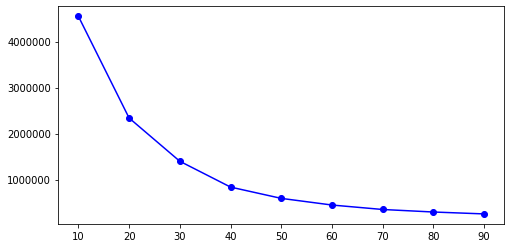

In [77]:

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(dataset) for k in range(10, 100, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 4))
plt.plot(range(10,100,10), inertias, "bo-")
# plt.savefig('temp/k-means.png')

In [0]:

# kmeans_model = KMeans(n_clusters=20).fit(dataset)

#write
# with open('/content/drive/My Drive/Colab Notebooks/multi-step-attack/temp/cluster.pickle', 'wb') as f:
#     pickle.dump(kmeans_model, f)

# read
with open('/content/drive/My Drive/Colab Notebooks/multi-step-attack/temp/cluster.pickle', 'rb') as f:
    cluster = pickle.load(f)


In [7]:
# print(dataset.shape,data.shape)
np.unique(cluster.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int32)

In [94]:
np.unique(kmeans_model.predict(dataset[data[data.stage == 3].index.tolist()]))

array([ 0,  1,  5,  6, 19], dtype=int32)

In [0]:
#聚类 长度缩减


#### training

In [0]:
DL = DataLoader()
# x_train, x_valid, y_train, y_valid
test_x, test_y = DL.train_test(np.load('temp/multi_dataset_dmz1.npy'),np.load('temp/multi_labels_dmz1.npy'))
train_x, valid_x, train_y, valid_y = DL.train_test(np.load('temp/multi_dataset_inside1.npy'),np.load('temp/multi_labels_inside1.npy'),split = True)

train_x, train_y = np.array(train_x).reshape(len(train_x),20,54), np.array(train_y).reshape(len(train_y),20,1)
valid_x, valid_y = np.array(valid_x).reshape(len(valid_x),20,54), np.array(valid_y).reshape(len(valid_y),20,1)
test_x, test_y = np.array(test_x).reshape(len(test_x),20,54), np.array(test_y).reshape(len(test_y),20,1)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [0]:

#------------  2.training  -------------

batch_size = 64
                               
train = Training(
    learning_rate = 0.001,
    batch_size = batch_size,
    window_size = 20,
    n_features = 54,
    n_classes = 6,
    current_time = current_time
)
                               
# train_gen = train.generator(train_x, train_y, batch_size)
                               
lstm_model = train.lstm_model()

lstm_history = lstm_model.fit(train_x, train_y, batch_size = batch_size, epochs = 5, validation_data=(valid_x,valid_y),callbacks = train.tensorBoard)
                               
# lstm_history = lstm_model.fit_generator(train_gen, steps_per_epoch=len(train_x)//batch_size,
#                                        epochs=5, callbacks=train.tensorBoard)

lstm_model.save("temp/multi_lstm_model_1226.h5")


NameError: name 'train_x' is not defined

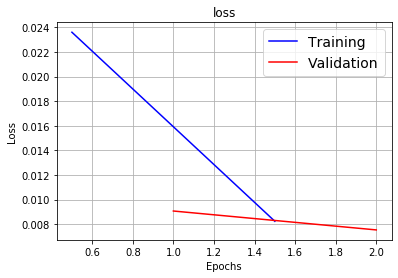

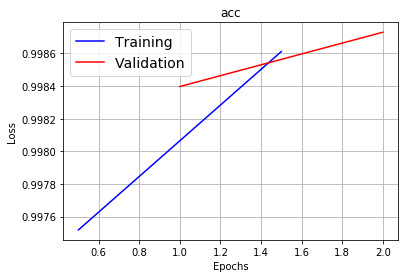

Performance measures on lstm-train data
Accuracy =  0.9987
F1 =  0.9986
Precision_score =  0.9987
recall_score =  0.9987
Normalized confusion matrix
[[9.99951642e-01 4.83582331e-07 0.00000000e+00 0.00000000e+00
  4.25552452e-06 4.36191263e-05]
 [1.68724280e-01 2.66117970e-01 5.65157750e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.58350658e-03 0.00000000e+00 9.34511435e-01 5.89050589e-02
  0.00000000e+00 0.00000000e+00]
 [3.07786185e-01 0.00000000e+00 4.27141811e-02 2.07224799e-01
  4.41786673e-01 4.88162070e-04]
 [4.17989418e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.57883598e-01 3.17460317e-04]
 [7.34476317e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.96340466e-06 9.92646273e-01]]
Performance measures on lstm-test data
Accuracy =  0.8938
F1 =  0.8743
Precision_score =  0.8646
recall_score =  0.8938
Normalized confusion matrix
[[9.69709684e-01 0.00000000e+00 0.00000000e+00 2.09786102e-06
  5.81946647e-04 2.97062715e-02]
 [9.93566879e-01 6.24203822e-03 1.273

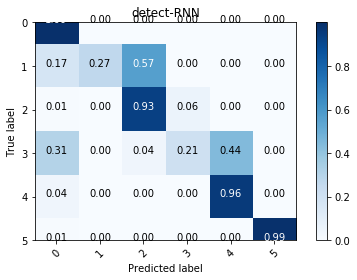

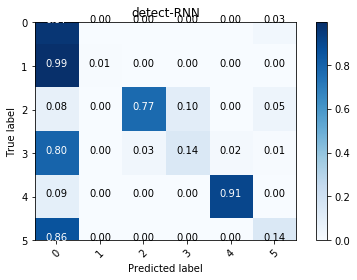

In [0]:
# lstm_model = keras.models.load_model("temp/multi_lstm_model_1226.h5")

#------------  3.evaluation  -------------

eva = Evaluation(current_time = current_time)

# test_gen = train.generator(test_x, test_y, batch_size)
# train_pred = lstm_model.predict_generator(train_gen, steps=len(train_x)//batch_size)

train_pred = lstm_model.predict(train_x)
valid_pred = lstm_model.predict(valid_x)
test_pred = lstm_model.predict(test_x)

eva.plot_learning_curves(lstm_history.history["loss"], lstm_history.history["val_loss"],"loss")
eva.plot_learning_curves(lstm_history.history["accuracy"], lstm_history.history["val_accuracy"],"acc")

# confusion matrix evaluation
eva.evaluation(np.array(train_y[:len(train_pred)]).flatten(),np.argmax(train_pred,axis=2).flatten(),"lstm-train")
eva.evaluation(np.array(test_y[:len(test_pred)]).flatten(),np.argmax(test_pred,axis=2).flatten(),"lstm-test")

### clustering and testing

In [0]:

# read
# with open('temp/cluster.pickle', 'rb') as f:
#     cluster = pickle.load(f)
    
data = pd.DataFrame(np.load('temp/multi_dataset_dmz1.npy'), columns=list(range(54)))
target = pd.DataFrame(cluster.labels_, columns=['label'])
all = pd.concat([data,target],axis=1)

cluster_map = {}
for key in all.label.unique():
    cluster_map[key] = all[all.label == key].mean().values[:-1]

In [0]:
# target.applymap(lambda x:cluster_map[x])
clu_data = []
for i in range(target.shape[0]):
    clu_data.append(cluster_map[cluster.predict(data.loc[i].values.reshape(1,-1))[0]])

In [0]:
with open('temp/clu_data_dmz1.pickle', 'rb') as f:
    clu_data_dmz1 = pickle.load(f)
    
with open('temp/clu_data_inside1.pickle', 'rb') as f:
    clu_data_inside1 = pickle.load(f)

In [0]:
DL = DataLoader()
clu_test_x, clu_test_y = DL.train_test(clu_data_inside1,np.load('temp/multi_labels_inside1.npy'))
clu_train_x, clu_train_y = DL.train_test(clu_data_dmz1,np.load('temp/multi_labels_dmz1.npy'))

clu_train_x, clu_train_y = np.array(clu_train_x).reshape(len(clu_train_x),20,54), np.array(clu_train_y).reshape(len(clu_train_y),20,1)
clu_test_x, clu_test_y = np.array(clu_test_x).reshape(len(clu_test_x),20,54), np.array(clu_test_y).reshape(len(clu_test_y),20,1)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [0]:
batch_size = 64
clu_train = Training(
    learning_rate = 0.001,
    batch_size = batch_size,
    window_size = 20,
    n_features = 54,
    n_classes = 6,
    current_time = current_time
)

clu_lstm_model = clu_train.lstm_model()

clu_lstm_history = clu_lstm_model.fit(clu_train_x, clu_train_y, batch_size=batch_size, epochs=5, callbacks=clu_train.tensorBoard)

# clu_lstm_model.save("temp/clu_multi_bilstm_model_1226.h5")

Train on 394049 samples
Epoch 1/5
394049/394049 [==============================] - 346s 879us/sample - loss: 0.0375 - accuracy: 0.9958
Epoch 2/5
394049/394049 [==============================] - 112s 285us/sample - loss: 0.0149 - accuracy: 0.9972
Epoch 3/5
394049/394049 [==============================] - 113s 286us/sample - loss: 0.0129 - accuracy: 0.9975
Epoch 4/5
394049/394049 [==============================] - 115s 292us/sample - loss: 0.0120 - accuracy: 0.9977
Epoch 5/5
394049/394049 [==============================] - 113s 287us/sample - loss: 0.0115 - accuracy: 0.9978


Performance measures on lstm-clu_train data
Accuracy =  0.9979
F1 =  0.9979
Precision_score =  0.9979
recall_score =  0.9979
Normalized confusion matrix
[[9.99543785e-01 2.68666068e-04 0.00000000e+00 4.47543684e-05
  0.00000000e+00 1.42794407e-04]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.84797297e-01 1.52027027e-02
  0.00000000e+00 0.00000000e+00]
 [1.76320755e-01 0.00000000e+00 3.30188679e-02 7.90660377e-01
  0.00000000e+00 0.00000000e+00]
 [5.79847909e-02 0.00000000e+00 0.00000000e+00 9.14448669e-02
  8.43916350e-01 6.65399240e-03]
 [1.39495847e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.78820942e-06 9.86044627e-01]]
Performance measures on lstm-clu_test data
Accuracy =  0.8846
F1 =  0.8307
Precision_score =  0.7844
recall_score =  0.8846
Normalized confusion matrix
[[9.99820659e-01 0.00000000e+00 0.00000000e+00 1.56270676e-04
  7.74823967e-06 1.53223616e-05]
 [1.00000000e+00 0.00000000e+

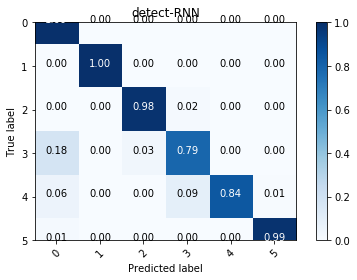

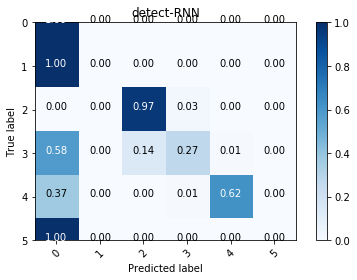

In [0]:

# clu_lstm_model = keras.models.load_model("temp/clu_multi_bilstm_model_1225.h5")

eva = Evaluation(current_time = current_time)

# batch_size = 64
# clu_train_gen = clu_train.generator(clu_clu_train_x, clu_clu_train_y, batch_size)

clu_train_pred = clu_lstm_model.predict(clu_train_x)
clu_test_pred = clu_lstm_model.predict(clu_test_x)

# confusion matrix evaluation
eva.evaluation(np.array(clu_train_y[:len(clu_train_pred)]).flatten(),np.argmax(clu_train_pred,axis=2).flatten(),"lstm-clu_train")
eva.evaluation(np.array(clu_test_y[:len(clu_test_pred)]).flatten(),np.argmax(clu_test_pred,axis=2).flatten(),"lstm-clu_test")

### raw data test

In [0]:
raw_data = pd.read_csv("../datasets/DARPA/dmz1_featue.csv")

In [0]:
raw_data['Protocol'] = raw_data.Protocol.astype('category').cat.codes
raw_data['sport'] = raw_data.sport.astype('category').cat.codes
raw_data['dport'] = raw_data.dport.astype('category').cat.codes

In [0]:
raw_data.head()

,Protocol,Length,delta_time,sport,dport,cat_Length,cat_delta_time,sip_diff,sip_com,dip_diff,dip_com,stage
0,18,-0.487795,-2.988772,28606,29549,L0,t5,0.384615,0.20,0.263158,0.10,0
1,7,-0.333644,-3.541074,28606,29549,L0,t5,0.384615,0.10,0.263158,0.30,0
2,18,-0.487795,-4.609352,28606,29549,L0,t4,0.384615,0.25,0.263158,0.15,0
3,18,2.740371,-0.874956,28606,29549,L9,t7,0.384615,0.30,0.263158,0.20,0
4,18,2.740371,-4.042162,28606,29549,L9,t5,0.384615,0.35,0.263158,0.25,0


In [0]:
DL = DataLoader()
raw_train_x, raw_train_y = DL.train_test(raw_data.drop(['cat_Length','cat_delta_time','stage'],axis=1).values,raw_data.stage.values)

raw_train_x,raw_train_y =  np.array(raw_train_x).reshape(len(raw_train_x),20,9), np.array(raw_train_y).reshape(len(raw_train_y),20,1)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [0]:
batch_size = 64

raw_train = Training(
    learning_rate = 0.001,
    batch_size = batch_size,
    window_size = 20,
    n_features = 9,
    n_classes = 6,
    current_time = current_time
)

raw_lstm_model = train.lstm_model()

lstm_history = raw_lstm_model.fit(raw_train_x, raw_train_y, batch_size = batch_size, epochs=10, callbacks=train.tensorBoard)

# raw_lstm_model.save("temp/raw_multi_bilstm_model_1225.h5")
# raw_lstm_model = keras.models.load_model("temp/raw_multi_bilstm_model_1225.h5")

eva = Evaluation(current_time = current_time)

raw_train_pred = raw_lstm_model.predict(raw_train_x)

eva.evaluation(np.array(raw_train_y).flatten(),np.argmax(raw_train_pred,axis=2).flatten(),"lstm-train")

Train on 394049 samples
Epoch 1/10
394049/394049 [==============================] - 86s 219us/sample - loss: 0.2848 - accuracy: 0.8978
Epoch 2/10
394049/394049 [==============================] - 86s 219us/sample - loss: 0.2609 - accuracy: 0.9036
Epoch 3/10
394049/394049 [==============================] - 84s 213us/sample - loss: 0.2578 - accuracy: 0.9068
Epoch 4/10
394049/394049 [==============================] - 85s 216us/sample - loss: 0.2643 - accuracy: 0.9140
Epoch 5/10
394049/394049 [==============================] - 84s 214us/sample - loss: 0.2700 - accuracy: 0.9141
Epoch 6/10
394049/394049 [==============================] - 87s 221us/sample - loss: 0.2595 - accuracy: 0.9146
Epoch 7/10
394049/394049 [==============================] - 85s 215us/sample - loss: 0.2508 - accuracy: 0.9164
Epoch 8/10
394049/394049 [==============================] - 84s 214us/sample - loss: 0.2224 - accuracy: 0.9279
Epoch 9/10
394049/394049 [==============================] - 85s 216us/sample - loss: 0.2

### stage probability;  attack probablity